In [1]:
from datetime import timedelta

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import orbit
from orbit.models import DLT,ETS, KTRLite, LGT, ARMA
from orbit.utils.simulation import make_trend, make_regression



In [2]:
from datetime import datetime, timedelta



In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
def daterange(start_date, end_date):
    delta = timedelta(hours=1)
    while start_date < end_date:
        yield start_date
        start_date += delta
        
hours = [datetime(2013, 1, 1, 14, 00)]        

start_date = datetime(2021, 1, 1, 00, 00)
end_date = datetime(2022, 1, 1, 00, 00)
i = 0
for single_date in daterange(start_date, end_date):
    hours[i]=hours.append(single_date.strftime("%Y-%m-%d %H:%M"))       
    i += i
hours = hours[1:8737]    

<class 'numpy.ndarray'>


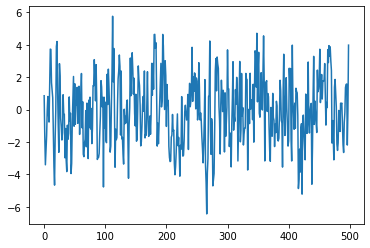

In [5]:
# make the data
n = 8736 # hourly for 1 year 

x0 = np.random.normal(0, 1, n)
x1 = np.random.normal(0, 1, n)
x2 = np.random.normal(0, 1, n)
x3 = np.random.normal(0, 1, n)
x4 = np.random.normal(0, 1, n)
x5 = np.random.normal(0, 1, n)
x6 = np.random.normal(0, 1, n)
x7 = np.random.normal(0, 1, n)
x8 = np.random.normal(0, 1, n)
x9 = np.random.normal(0, 1, n)

X = np.vstack([x0, x1]).transpose()
   
    

eta = np.random.normal(0, 1, n)
rho = [0.45, -0.25, 0.25]
beta = [1.00, -1.00]
y = eta.copy()
for i in range(2, n):
    y[i] = rho[0]*y[i-1] + rho[1]*y[i-24] + rho[2]*y[i-168] + x0[i]*beta[0]+ x1[i]*beta[1]+ eta[i]

    
    
#plt.plot(y)
plt.plot(y[1:500])
print(type(X))

In [6]:
df = pd.DataFrame(X, columns=['a1', 'a2'])
df['hours'] = hours
df['y'] = y

In [18]:
mod = ARMA(
        regressor_col=['a1', 'a2'],
        lm_first=False,
        estimator='stan-mcmc',
        date_col = 'hours',
        response_col = 'y',
        num_of_ar_lags = 1,
        ar_lags = [1],
        num_of_ma_lags = 1,
        ma_lags = [1],
    
        
    
)

here


In [19]:
mod.fit(df)

here in orbit/orbit/forecaster/full_bayes.py
here in orbit/orbit/estimators/stan_estimator.py
1.0
{'RESPONSE': array([-2.13344799,  0.85583019, -1.65245808, ...,  0.75509505,
        1.17854498,  0.8830605 ]), 'RESPONSE_SD': 2.356304705866088, 'NUM_OF_OBS': 8736, 'WITH_MCMC': 1, 'K': 0, 'X': array([], shape=(8736, 0), dtype=float64), 'P': 0, 'Q': 0, 'LAG AR': [], 'LAG_MA': [], 'LM_FIRST': 0, 'T_STAR': 1.0}


RuntimeError: Exception: variable does not exist; processing stage=data initialization; variable name=t_star; base type=double  (in 'unknown file name' at line 20)


In [ ]:
hours[8735]

In [ ]:
df